# Data Analysis Pipeline for the CAIS Paper "Qualitative Research Meets AI: A Mixed-Methods Approach to Explaining Semi-Structured Decisions" 

This notebook provides an end-to-end implementation of the versatile mixed-methods data analysis strategy proposed in the CAIS paper “Qualitative Research Meets AI: A Mixed-Methods Approach to Explaining Semi-Structured Decisions.” The pipeline is designed to handle common data-structure limitations inherent to mixed-methods research, including high dimensionality, substantial missingness (where missingness may be informative rather than noise), and (quasi-)separation. Researchers working with mixed-methods datasets—regardless of research design or phenomenon of interest—can adapt this pipeline to their own data to generate rigorous, interpretable results and high-quality meta-inferences. Please see the paper for conceptual justification, methodological details, and reporting guidance.

The pipeline includes reproducible code for:


### Phase 3 — Step 1: Training and Evaluating the Gradient Boosting Machine (GBM)

Step 1 specifically includes:

- Defining a function to compute GBM performance on the holdout (previously unseen) test data
- Hyperparameter optimization using grid search
- Training the GBM with the optimized hyperparameters
- Calibrating the classification threshold using Youden’s J index
- Evaluating GBM performance on the holdout (previously unseen) test data


### Phase 3 — Step 2: Applying XAI for Explanation

Step 2 specifically includes:

- Computing Shapley values to quantify the contribution of each factor to GBM predictions in the holdout (previously unseen) test data
- Identifying the key factors (in the CAIS paper’s empirical context, this corresponds to identifying the most influential factors among the many available to the decision-maker)
- Explaining each individual observation (in the CAIS paper’s empirical context, this corresponds to illustrating why a decision-maker made a specific decision)
- Interpreting the overall effect of each key factor on GBM predictions (in the CAIS paper’s empirical context, this corresponds to uncovering global patterns in how each key factor contributes to decision outcomes)

## Import Necessary Libraries

If you encounter import errors, make sure the following packages are installed: pandas, numpy, shap, matplotlib, lightgbm, and scikit-learn. If any import fails, you may need to install the missing package using pip (e.g., pip install pandas numpy shap lightgbm scikit-learn matplotlib).

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV


## Mixed-Methods Design, Phase 3 — Step 1: Training and Evaluating the Gradient Boosting Machine (GBM)



### Define a Function for Computing GBM Performance (Accuracy, Precision, Recall, Specificity, F1,	AUROC, etc.) on the Holdout (Previously Unseen) Test Data


In [3]:
def getClassificationMetrics(y_test, y_predicted, prob):
    """
    Compute key classification metrics, including:
    - Accuracy, Precision (for both classes), Recall, Specificity
    - F1-score, ROC AUC, PR AUC
    - Confusion matrix elements: TP, FP, TN, FN
    - Positive prediction rate and class balance

    Returns:
        pd.DataFrame: A summary of metrics.
    """
    accuracy = round(accuracy_score(y_test, y_predicted), 2)
    precision = round(precision_score(y_test, y_predicted), 2)
    precision_0 = round(precision_score(y_test, y_predicted, pos_label=0), 2)
    recall = round(recall_score(y_test, y_predicted), 2)
    specificity = round(recall_score(y_test, y_predicted, pos_label=0), 2)
    f1 = round(f1_score(y_test, y_predicted), 2)
    f1_0 = round(f1_score(y_test, y_predicted, pos_label=0), 2)
    p, r, _ = precision_recall_curve(y_test, prob)
    pr_auc = round(auc(r, p), 2)

    roc = round(roc_auc_score(y_test, prob), 2) if len(np.unique(y_test)) > 1 else np.NaN

    posPredRate = round(np.mean(y_predicted) * 100, 2)
    posRate = round(np.mean(y_test) * 100, 2)

    temp = pd.DataFrame({'actual': y_test, 'prediction': y_predicted})
    tp = len(temp[(temp['actual'] == 1) & (temp['prediction'] == 1)])
    tn = len(temp[(temp['actual'] == 0) & (temp['prediction'] == 0)])
    fp = len(temp[(temp['actual'] == 0) & (temp['prediction'] == 1)])
    fn = len(temp[(temp['actual'] == 1) & (temp['prediction'] == 0)])

    return pd.DataFrame({
        'metrics': ["Accuracy", "Precision", "Recall", "specificity", "precision_0", "F1", "F1_0",
                    "PR AUC", "ROC", 'TP', 'FP', 'TN', 'FN',
                    'PredictionRate', 'positiveClassRate', 'Count'],
        'value': [accuracy, precision, recall, specificity, precision_0, f1, f1_0,
                  pr_auc, roc, tp, fp, tn, fn, posPredRate, posRate, len(y_test)]
    })


### Load Training and Holdout (Previously Unseen) Test Data

The model is trained only on the training dataset and evaluated on the holdout (previously unseen) test dataset.

**Note: Data Availability and Use**

The training and test datasets required to replicate the analyses, results, figures, and findings reported in the CAIS paper are publicly available via Harvard Dataverse at the following DOI:

https://doi.org/10.7910/DVN/WAWPJR

To run the notebook, download the training and test datasets from Dataverse and place them in the same directory as this notebook, or update the data-loading paths in the notebook accordingly.

Alternatively, users may substitute their own training and test datasets in the data-loading cell below.

In [4]:
train=pd.read_csv('MixedMethods_JudicialDecisions_Train.csv')
test=pd.read_csv('MixedMethods_JudicialDecisions_Test.csv')
predictors = train.drop(columns=['CaseID', 'Outcome']).columns


### Hyperparameter Optimization with Grid Search

We perform hyperparameter tuning using 5-fold cross-validation on the training data. Grid search is employed to systematically evaluate candidate hyperparameter combinations and identify the configuration that yields the best cross-validated performance for the GBM.

In [5]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.3, 0.2, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [5, 6, 7, 8],
    'feature_fraction': [0.8, 0.9, 1.0],
    'lambda_l1': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'force_col_wise': [True],
    'verbose': [0],
    'boosting': ['gbdt'],
    'objective': ['binary'],
    'metric': ['auc']
}

grid = GridSearchCV(
    lgb.LGBMClassifier(random_state=100),
    param_grid,
    scoring='roc_auc',
    refit=True,
    verbose=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
)

grid.fit(train[predictors], train['Outcome'])
best_params = grid.best_params_
print(best_params)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
{'boosting': 'gbdt', 'feature_fraction': 0.8, 'force_col_wise': True, 'lambda_l1': 0.5, 'learning_rate': 0.3, 'max_depth': 5, 'metric': 'auc', 'n_estimators': 50, 'num_leaves': 15, 'objective': 'binary', 'verbose': 0}



### Train the GBM on the Training Data

We train the selected GBM (LightGBM) using the optimal hyperparameters identified in the previous step. Alternatively, the model may be trained using manually specified hyperparameter values, depending on researcher preference or experimental design.

In [6]:
# Merge the discovered best_params with a fixed to ensure exact reproducibility of results
params_lgb = {**best_params, 'random_state': 100}

# Extract number of boosting rounds
num_round = params_lgb.pop('n_estimators')

d_train = lgb.Dataset(train[predictors], train['Outcome'])
model_lgb = lgb.train(params_lgb, d_train, num_boost_round=num_round)


### Compute the Optimal Classification Threshold (Youden’s J Index)

To convert GBM-predicted probabilities into binary classifications, we use Youden’s J index to determine the optimal classification threshold. The threshold is selected by maximizing the trade-off between sensitivity and specificity, computed across 5 cross-validation folds on the training data. The resulting threshold is then applied to generate binary predictions on the holdout (previously unseen) test data.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
youden_thresholds = []

# Re-merge fixed seed into best params
params_with_seed = {**best_params, 'random_state': 100}

for train_idx, valid_idx in cv.split(train[predictors], train['Outcome']):
    X_train, X_valid = train[predictors].iloc[train_idx], train[predictors].iloc[valid_idx]
    y_train, y_valid = train['Outcome'].iloc[train_idx], train['Outcome'].iloc[valid_idx]
    
    model = lgb.LGBMClassifier(**params_with_seed)
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_valid)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_valid, y_probs)
    best_idx = np.argmax(tpr - fpr)
    youden_thresholds.append(thresholds[best_idx])

final_threshold = np.mean(youden_thresholds)
print(f"Average Youden-optimal threshold across folds: {final_threshold:.4f}")

Average Youden-optimal threshold across folds: 0.4833



### Evaluate the GBM on Holdout (Previously Unseen) Test Data

In [8]:
pred_probs = model_lgb.predict(test[predictors])
pred_class = np.where(pred_probs >= final_threshold, 1, 0)
test['pred_class'] = pred_class
getClassificationMetrics(test['Outcome'], pred_class, pred_probs)

,metrics,value
0,Accuracy,0.99
1,Precision,0.97
2,Recall,1.00
3,specificity,0.99
4,precision_0,1.00
5,F1,0.98
6,F1_0,1.00
7,PR AUC,0.98
8,ROC,1.00
9,TP,32.00



## Mixed-Methods Design, Phase 3 — Step 2: Applying XAI for Explanation

### Compute Shapley Values for Each GBM Prediction in the Holdout (Previously Unseen) Test Data

In [9]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(test[predictors])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



### Generate a Bar Plot of the Key (Top Ten Most Influential) Factors
The bar plot can also be used to visually identify the “elbow point” in factor importance, which helps determine where the marginal contribution of additional factors begins to level off.

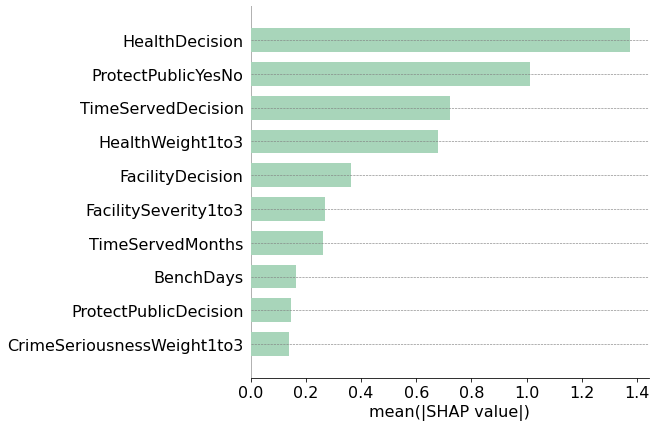

In [10]:
plt.ioff()  # Turn off interactive mode to avoid automatic popups during save

# Generate SHAP bar plot
shap.summary_plot(
    shap_values[1],
    test[predictors],
    plot_type="bar",
    show=False,
    color='#A8D5BA',
    max_display=10
)

# Get figure and axis
fig = plt.gcf()
fig.set_size_inches(9, 6)
ax = plt.gca()

# Customize axis
ax.yaxis.grid(linestyle='--', linewidth='0.6', color='grey')
plt.yticks(fontsize=16)
ax.tick_params(axis='x', labelsize=16, colors='black')
ax.tick_params(axis='y', colors='black')
ax.set_xlabel("mean(|SHAP value|)", fontsize=16)

# Try to modify colorbar if present
if len(fig.axes) > 1:
    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=16)

# Save plot to file
plt.savefig('SHAP_Bar.png', format="png", dpi=600, bbox_inches='tight')

# Finally show the plot inline
plt.show()

### Generate Beeswarm Plot of the Key Factors
The beeswarm plot illustrates the overall effect of each key factor across the holdout (previously unseen) test data.

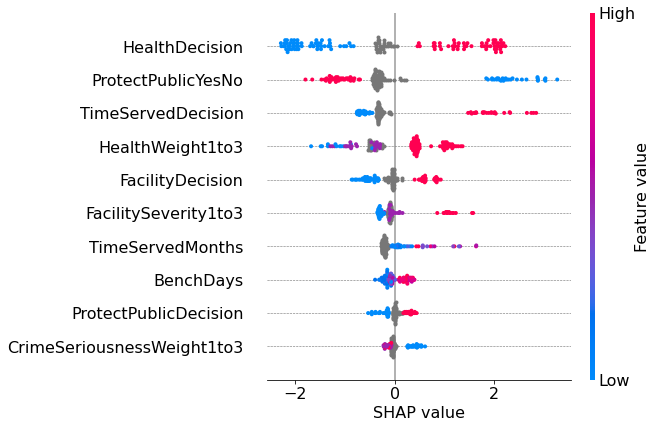

In [11]:
# Generate Shapley beeswarm plot on Test data
plt.ioff()
shap.summary_plot(
    shap_values[1],
    test[predictors],
    plot_type="dot",
    show=False,
    max_display=10
)

# Get the current figure and axes objects
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(9, 6)

# Modify main plot parameters
ax.tick_params(labelsize=16)
ax.set_xlabel("SHAP value", fontsize=16)
ax.yaxis.grid(linestyle='--', linewidth='0.6', color='grey')
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Safely modify colorbar if present
if len(fig.axes) > 1:
    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=16)
    cb_ax.set_ylabel("Feature value", fontsize=16)

# Save plot to file
plt.savefig('SHAP_BeeSwarm.png', format="png", dpi=600, bbox_inches='tight')

# Show the plot inline
plt.show()


### Generate Force Plots for Individual Cases

These plots illustrate how each factor contributes to an individual case-level prediction, pushing it toward 1 or 0 (i.e., “Grant” or “Deny,” as defined in the CAIS paper).

In [12]:
shap.initjs()

### Example of Explaining a True Positive Case:
Below, we illustrate why the GBM correctly predicts a specific “1” outcome for a case in which the observed (actual) outcome is also “1.”
In the CAIS paper’s empirical context, this corresponds to illustrating why a decision-maker (judge) made a specific (“Grant”) decision.

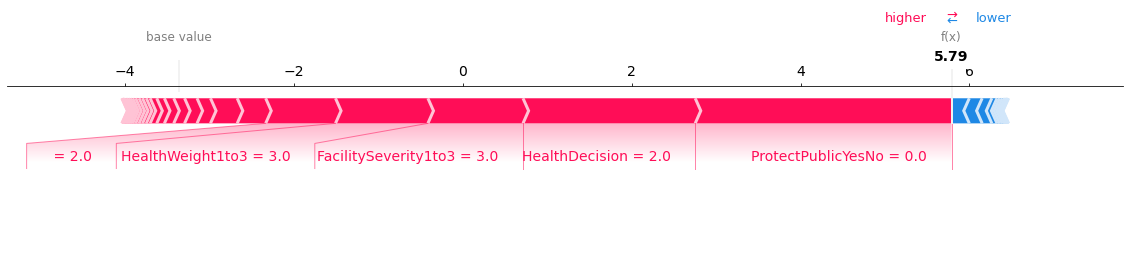

In [30]:
# Show all forces, label only top 4 features to reduce overlap and clutter
index = 19 # Set to the test index of a True Positive example you want to explain
top_n =4 # Choose any index number to display

shap_vals = shap_values[1][index]
feature_vals = test.iloc[index][predictors]

# Get indices of top SHAP features (by absolute value)
top_idx = np.argsort(np.abs(shap_vals))[-top_n:]

# Label only top features; blank for the rest
feature_names = [
    predictors[i] if i in top_idx else "" for i in range(len(predictors))
]

# Set global matplotlib font sizes BEFORE calling shap.force_plot
plt.rcParams.update({
    'font.size': 14,           # general font size
    'xtick.labelsize': 14,     # axis tick font size
    'ytick.labelsize': 14,
    'axes.titlesize': 14,      # axis title
    'axes.labelsize': 14,
})


# Display and save force plot
shap_plot = shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_vals,
    features=feature_vals,
    feature_names=feature_names,
    matplotlib=True,
    show=False
)

# To increase SHAP label size
# Loop through all Text objects in the current figure and increase the font size
# The SHAP labels are drawn as Text objects on the plot.
# We check the text content to confirm it looks like a feature label (e.g., contains "=").
NEW_FEATURE_FONT_SIZE = 14

# Iterate over all artists (objects) in the figure
for artist in shap_plot.get_children():
    # Check if the artist is an Axes object (where the plot elements reside)
    if isinstance(artist, plt.Axes):
        # Iterate over all text elements in the Axes
        for text in artist.texts:
            # The feature labels contain an "=" sign (e.g., "Feature=Value").
            # The tick labels do not. This is a heuristic to target the correct text.
            if "=" in text.get_text():
                text.set_fontsize(NEW_FEATURE_FONT_SIZE)
#END: To increase SHAP label size

# Save
shap_plot.savefig("TruePositive_Top4Labels.png", format='png', dpi=600, bbox_inches='tight', facecolor='white')

# Show inline
plt.show()

### Example of Explaining a True Negative Case:
Below, we illustrate why the GBM correctly predicts a specific “0” outcome for a case in which the observed (actual) outcome is also “0.”
In the CAIS paper’s empirical context, this corresponds to illustrating why a decision-maker (judge) made a specific (“Deny”) decision.

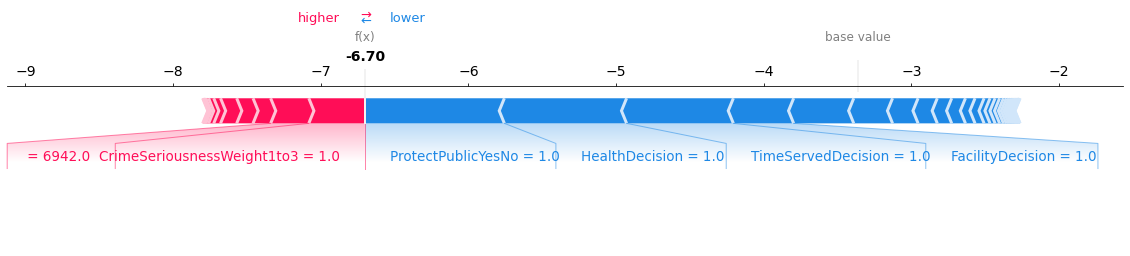

In [34]:
# True Negative case example — show all forces, label only top 4 features to reduce overlap and clutter
index = 133  # Set to the test index of a True Negative example you want to explain
top_n = 4    # Number of top features to label

shap_vals = shap_values[1][index]
feature_vals = test.iloc[index][predictors]

# Get indices of top N absolute SHAP values
top_idx = np.argsort(np.abs(shap_vals))[-top_n:]

# Find the index of the most positive SHAP value
most_pos_idx = np.argmax(shap_vals)

# Ensure the most positive feature is included in the labels
final_label_idx = set(top_idx)
final_label_idx.add(most_pos_idx)

# Create feature name list: label only selected ones
feature_names = [
    predictors[i] if i in final_label_idx else "" for i in range(len(predictors))
]

# Create force plot
shap_plot = shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_vals,
    features=feature_vals,
    feature_names=feature_names,
    matplotlib=True,
    show=False
)


# To increase SHAP label size
# Loop through all Text objects in the current figure and increase the font size
# The SHAP labels are drawn as Text objects on the plot.
# We check the text content to confirm it looks like a feature label (e.g., contains "=").
NEW_FEATURE_FONT_SIZE = 13.5

# Iterate over all artists (objects) in the figure
for artist in shap_plot.get_children():
    # Check if the artist is an Axes object (where the plot elements reside)
    if isinstance(artist, plt.Axes):
        # Iterate over all text elements in the Axes
        for text in artist.texts:
            # The feature labels contain an "=" sign (e.g., "Feature=Value").
            # The tick labels do not. This is a heuristic to target the correct text.
            if "=" in text.get_text():
                text.set_fontsize(NEW_FEATURE_FONT_SIZE)
#END: To increase SHAP label size


# Save the plot
shap_plot.savefig("TrueNegative_Top4PlusMostPos.png", format='png', dpi=600, bbox_inches='tight', facecolor='white')

# Show inline
plt.show()